# 1. Create Synthetic data (V5)

In [1]:
import torch
import numpy as np
import pandas as pd

import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical

In [2]:
xdim = 100  # number of billing codes
T = 10  # total time steps
special_X = True

pretrain_size = 500_000
train_size = 10_000
eval_size = 10_000

add_special_tokens = True


In [3]:
def is_in(z, a=1, b=3):
    return (z >= a ) * (z <= b)

In [4]:
N = pretrain_size

# model parameters
Psi = torch.arange(0, xdim * 0.01, 0.01)

# random variables
Z_true = torch.zeros((N, T)) # latent 
X = torch.zeros((N, T)) # observed
X_onehot = torch.zeros((N, T, xdim))
Y = torch.zeros((N,1))

for t in range(0,T):
    # Zit | Zi,t-1, Yi
    meanz = (0.9 * Z_true[:, t - 1]) if t != 0 else torch.zeros((N,))
    Zt = Normal(meanz, 1)
    Z_true[:, t] = Zt.sample()
    
    # Xit | Zit
    Psi_z = Z_true[:,t].view(N, 1) * Psi.view(1, xdim)
    PX = F.softmax(Psi_z, dim = 1)
    Xt = Categorical(PX)
    Xit = Xt.sample()
    X[:, t] = Xit
    X_onehot[:, t] = F.one_hot(Xit, num_classes = xdim)

for t in range(T-2):
    Y[:,0] += is_in(Z_true[:,t]) * is_in(Z_true[:,t+1]) * is_in(Z_true[:,t+2])

# Truncate the Y values which are greater than 1.
Y = torch.cat((Y, torch.ones((N,1))), 1).min(dim = 1).values


# Save data to txt file, separate with whitespace ' '.
X_ = X.cpu().data.numpy().astype(int)
Y_ = Y.cpu().data.numpy().astype(int)

if special_X:
    # If X[t] == 64, then X[t+2] == 65
    for t in range(T-2):
        X_special_loc = (X_[:, t] == 64)
        X_[X_special_loc, t+2] = 65
    
np.savetxt('synthetic_pretrain_X.txt', X_, delimiter=' ', fmt='%s')

In [5]:
N = train_size  # number of patients

# model parameters
Psi = torch.arange(0, xdim * 0.01, 0.01)

# random variables
Z_true = torch.zeros((N, T)) # latent 
X = torch.zeros((N, T)) # observed
X_onehot = torch.zeros((N, T, xdim))
Y = torch.zeros((N,1))

for t in range(T):
    # Zit | Zi,t-1
    meanz = (0.9 * Z_true[:, t - 1]) if t > 0 else torch.zeros((N,))
    Zt = Normal(meanz, 1)
    Z_true[:, t] = Zt.sample()
    
    # Xit | Zit
    Psi_z = Z_true[:, t].view(N, 1) * Psi.view(1, xdim)
    PX = F.softmax(Psi_z, dim = 1)
    Xt = Categorical(PX)
    Xit = Xt.sample()
    X[:, t] = Xit
    X_onehot[:, t] = F.one_hot(Xit, num_classes = xdim)

for t in range(T-2):
    Y[:,0] += is_in(Z_true[:,t]) * is_in(Z_true[:,t+1]) * is_in(Z_true[:,t+2])

# Truncate the Y values which are greater than 1.
Y = torch.cat((Y, torch.ones((N,1))), 1).min(dim = 1).values


# Save data to txt file, separate with whitespace ' '.
X_ = X.cpu().data.numpy().astype(int)
Y_ = Y.cpu().data.numpy().astype(int)

if special_X:
    # If X[t] == 64, then X[t+2] == 65
    for t in range(T-2):
        X_special_loc = (X_[:, t] == 64)
        X_[X_special_loc, t+2] = 65
    
np.savetxt('synthetic_train_X.txt', X_, delimiter=' ', fmt='%s')
np.savetxt('synthetic_train_Y.txt', Y_, delimiter=' ', fmt='%s')

In [6]:
N = eval_size  # number of patients

# model parameters
Psi = torch.arange(0, xdim * 0.01, 0.01)

# random variables
Z_true = torch.zeros((N, T)) # latent 
X = torch.zeros((N, T)) # observed
X_onehot = torch.zeros((N, T, xdim))
Y = torch.zeros((N,1))

for t in range(0,T):
    # Zit | Zi,t-1, Yi
    meanz = (0.9 * Z_true[:, t - 1]) if t != 0 else torch.zeros((N,))
    Zt = Normal(meanz, 1)
    Z_true[:, t] = Zt.sample()
    
    # Xit | Zit
    Psi_z = Z_true[:,t].view(N, 1) * Psi.view(1, xdim)
    PX = F.softmax(Psi_z, dim = 1)
    Xt = Categorical(PX)
    Xit = Xt.sample()
    X[:, t] = Xit
    X_onehot[:, t] = F.one_hot(Xit, num_classes = xdim)

for t in range(T-2):
    Y[:,0] += is_in(Z_true[:,t]) * is_in(Z_true[:,t+1]) * is_in(Z_true[:,t+2])

# Truncate the Y values which are greater than 1.
Y = torch.cat((Y, torch.ones((N,1))), 1).min(dim = 1).values


# Save data to txt file, separate with whitespace ' '.
X_ = X.cpu().data.numpy().astype(int)
Y_ = Y.cpu().data.numpy().astype(int)

if special_X:
    # If X[t] == 64, then X[t+2] == 65
    for t in range(T-2):
        X_special_loc = (X_[:, t] == 64)
        X_[X_special_loc, t+2] = 65
    
np.savetxt('synthetic_eval_X.txt', X_, delimiter=' ', fmt='%s')
np.savetxt('synthetic_eval_Y.txt', Y_, delimiter=' ', fmt='%s')

# 2 Create customized Tokenizer.

This task is separated into three substeps:

*NOTE: Maybe I didn't do it completely correct in this version. Now it just can work.*

1. Create a word-level vocabulary based on `Tokenizer` library. See [Issue 232](https://github.com/huggingface/tokenizers/issues/232), [Issue 243](https://github.com/huggingface/tokenizers/issues/243#issuecomment-617860020) for codes.

2. Create our own `WordLevelTokenizer` based on `Tokenizer` library. 
See [whitespace/word level](https://github.com/huggingface/tokenizers/issues/244) for codes.

3. Create our own `WordLevelBertTokenizer` that can be used to train Transformers(Bert/Roberta) by wrapping the class from last step based on `Transformer` library. See [Why doesn't this library share the same tokenizer api as the transformers library?](https://github.com/huggingface/tokenizers/issues/259) for tutorial to do this.

## 2.1 Create a word-level vocabulary

In [7]:
# %%time 
import time
import os
from pathlib import Path

from tokenizers import Tokenizer, trainers
from tokenizers.models import BPE, WordLevel
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import WhitespaceSplit, CharDelimiterSplit
from tokenizers.processors import BertProcessing

# We build our custom tokenizer:
tokenizer = Tokenizer(WordLevel()) 
tokenizer.normalizer = Lowercase()
tokenizer.pre_tokenizer = WhitespaceSplit()
# tokenizer.pre_tokenizer = CharDelimiterSplit(',')

# We can train this tokenizer by giving it a list of path to text files:
trainer = trainers.BpeTrainer(special_tokens=
        ["[SEP]",
        "[PAD]",
        "[CLS]",
        "[UNK]",
        "[MASK]",
    ])

files = [str(x) for x in Path(".").glob("**/synthetic_pretrain_X.txt")]

tokenizer.train(trainer, files)

# Add post_processor.
tokenizer.post_processor = BertProcessing(
    ("[SEP]", tokenizer.token_to_id("[SEP]")), # SEP 
    ("[CLS]", tokenizer.token_to_id("[CLS]")), # CLS
)

    
if not os.path.exists('Synthetic'):
    os.makedirs('Synthetic')
    
# Set truncation.
tokenizer.enable_truncation(max_length=128)

# And now it is ready, we can save the vocabulary with
tokenizer.model.save("./Synthetic")

# And simply use it
tokenizer.encode('30 63 48 31 31').tokens

['[CLS]', '30', '63', '48', '31', '31', '[SEP]']

## 2.2 Create WordLevelTokenizer

In [8]:
from typing import Optional, Union

import tokenizers
from tokenizers.models import WordLevel, TokenizedSequence, TokenizedSequenceWithOffsets
from tokenizers import Tokenizer, Encoding, AddedToken
from tokenizers.normalizers import Lowercase, Sequence, unicode_normalizer_from_str

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import CharDelimiterSplit, WhitespaceSplit
from tokenizers.implementations import BaseTokenizer 


class WordLevelTokenizer(BaseTokenizer):
    """ WordLevelBertTokenizer
    Represents a simple word level tokenization for BERT.
    """

    def __init__(
        self,
        vocab_file: Optional[str] = None,
        unk_token: Union[str, AddedToken] = "[UNK]",
        sep_token: Union[str, AddedToken] = "[SEP]",
        cls_token: Union[str, AddedToken] = "[CLS]",
        pad_token: Union[str, AddedToken] = "[PAD]",
        mask_token: Union[str, AddedToken] = "[MASK]",
        
        
        lowercase: bool = False,
        unicode_normalizer: Optional[str] = None,
    ):
        if vocab_file is not None:
            tokenizer = Tokenizer(WordLevel(vocab_file, unk_token='[UNK]'))
        else:
            tokenizer = Tokenizer(WordLevel())

        # Let the tokenizer know about special tokens if they are part of the vocab
        if tokenizer.token_to_id(str(unk_token)) is not None:
            tokenizer.add_special_tokens([str(unk_token)])
        if tokenizer.token_to_id(str(sep_token)) is not None:
            tokenizer.add_special_tokens([str(sep_token)])
        if tokenizer.token_to_id(str(cls_token)) is not None:
            tokenizer.add_special_tokens([str(cls_token)])
        if tokenizer.token_to_id(str(pad_token)) is not None:
            tokenizer.add_special_tokens([str(pad_token)])
        if tokenizer.token_to_id(str(mask_token)) is not None:
            tokenizer.add_special_tokens([str(mask_token)])

        # Check for Unicode normalization first (before everything else)
        normalizers = []

        if unicode_normalizer:
            normalizers += [unicode_normalizer_from_str(unicode_normalizer)]

        if lowercase:
            normalizers += [Lowercase()]

        # Create the normalizer structure
        if len(normalizers) > 0:
            if len(normalizers) > 1:
                tokenizer.normalizer = Sequence(normalizers)
            else:
                tokenizer.normalizer = normalizers[0]

        tokenizer.pre_tokenizer = WhitespaceSplit()
#         tokenizer.pre_tokenizer = CharDelimiterSplit(',')

        if vocab_file is not None:
            cls_token_id = tokenizer.token_to_id(str(cls_token))
            if cls_token_id is None:
                raise TypeError("cls_token not found in the vocabulary")
                
            sep_token_id = tokenizer.token_to_id(str(sep_token))
            if sep_token_id is None:
                raise TypeError("sep_token not found in the vocabulary")


            tokenizer.post_processor = tokenizers.processors.BertProcessing(
                (str(sep_token), sep_token_id), (str(cls_token), cls_token_id)
            )

        parameters = {
            "model": "WordLevel",
            "unk_token": unk_token,
            "sep_token": sep_token,
            "cls_token": cls_token,
            "pad_token": pad_token,
            "mask_token": mask_token,
            "lowercase": lowercase,
            "unicode_normalizer": unicode_normalizer,
        }

        super().__init__(tokenizer, parameters)

## 2.3 Create WordLevelBertTokenizer

In [9]:
from transformers import PreTrainedTokenizerFast
from typing import List, Optional, Union

class WordLevelBertTokenizer(PreTrainedTokenizerFast):

    def __init__(
        self,
        tokenizer,
        bos_token="[CLS]",
        eos_token="[SEP]",
        sep_token="[SEP]",
        cls_token="[CLS]",
        unk_token="[UNK]",
        pad_token="[PAD]",
        mask_token="[MASK]",
        **kwargs
    ):
        super().__init__(
            tokenizer,
            bos_token=bos_token,
            eos_token=eos_token,
            unk_token=unk_token,
            sep_token=sep_token,
            cls_token=cls_token,
            pad_token=pad_token,
            mask_token=mask_token,
            **kwargs,
        )
        
    # Copied from [BertTokenizer]
    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (:obj:`bool`, `optional`, defaults to :obj:`False`):
                Set to True if the token list is already formatted with special tokens for the model

        Returns:
            :obj:`List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]
    
    # Copied from [BertTokenizer]
    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:

        - single sequence: ``[CLS] X [SEP]``
        - pair of sequences: ``[CLS] A [SEP] B [SEP]``

        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.

        Returns:
            :obj:`List[int]`: list of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep


## 2.4 Instantize Tokenizes we have. 

In [10]:
tokenizer = WordLevelTokenizer('./Synthetic/vocab.json')
BertTokenizer = WordLevelBertTokenizer(tokenizer = tokenizer)

len(BertTokenizer)

105

# 3 Instantize Bert, Dataset, Data_collator, Trainer.

In [11]:
# !pip install -U numpy
import torch
from transformers import BertForMaskedLM
import os

# Specify visible CUDA for the script, try to avoid encounder out of memory issue.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"

TRAIN_NEW_MODEL = True

if TRAIN_NEW_MODEL:
    
    from transformers import BertConfig
    
    config = BertConfig(
        vocab_size=len(BertTokenizer),
        max_position_embeddings=20,
        num_attention_heads=1,
        num_hidden_layers=2,
#         hidden_size
        type_vocab_size=1,

    )

else:
    
    # load a pre-trained model.
    from transformers import AutoConfig
    
    config = AutoConfig.from_pretrained(pretrained_model_name_or_path)
    
model = BertForMaskedLM(config=config)

print(f'The Bert model contains {model.num_parameters()} parameters.')

The Bert model contains 15456873 parameters.


In [12]:
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer

class LineByLineTextDataset(Dataset):
    """
    This will be superseded by a framework-agnostic approach
    soon.
    """

    def __init__(self, tokenizer: PreTrainedTokenizer, file_path: str, block_size: int):
        assert os.path.isfile(file_path)
        # Here, we do not cache the features, operating under the assumption
        # that we will soon use fast multithreaded tokenizers from the
        # `tokenizers` repo everywhere =)
#         logger.info("Creating features from dataset file at %s", file_path)

        with open(file_path, encoding="utf-8") as f:
            lines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

        batch_encoding = tokenizer.batch_encode_plus(lines, add_special_tokens=add_special_tokens, max_length=block_size, truncation=True)
        self.examples = batch_encoding["input_ids"]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i) -> torch.Tensor:
        return torch.tensor(self.examples[i], dtype=torch.long)


In [13]:
%%time
# from transformers import LineByLineTextDataset

# Define a dataset.
# Each output is the encoded row.
dataset = LineByLineTextDataset(
    tokenizer=BertTokenizer,
    file_path="./synthetic_pretrain_X.txt",
    block_size=20,
)

# Define a data-collator. 
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=BertTokenizer, mlm=True, mlm_probability=0.15,
)

CPU times: user 23.1 s, sys: 6.22 s, total: 29.3 s
Wall time: 7.05 s


In [14]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./Synthetic/finetune_v1",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=32,
    save_steps=10_000,
#     save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    prediction_loss_only=True,
)

In [15]:
%%time
trainer.train()



CPU times: user 13min 38s, sys: 13.6 s, total: 13min 52s
Wall time: 13min 49s


TrainOutput(global_step=31250, training_loss=4.221174722625732)

In [16]:
trainer.save_model("./Synthetic")

In [17]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="./Synthetic",
    tokenizer=BertTokenizer
)

/home/liutianc/.local/lib/python3.7/site-packages/transformers/modeling_auto.py:792: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [18]:
# We can see that the Bert can fill the mask at least.
fill_mask("1 64 0 [MASK] 21")

[{'sequence': '[CLS] 1 64 0 65 21 [SEP]',
  'score': 0.9872227907180786,
  'token': 15,
  'token_str': '65'},
 {'sequence': '[CLS] 1 64 0 [CLS] 21 [SEP]',
  'score': 0.00032277213176712394,
  'token': 2,
  'token_str': '[CLS]'},
 {'sequence': '[CLS] 1 64 0 70 21 [SEP]',
  'score': 0.000313008320517838,
  'token': 63,
  'token_str': '70'},
 {'sequence': '[CLS] 1 64 0 5 21 [SEP]',
  'score': 0.00027593132108449936,
  'token': 10,
  'token_str': '5'},
 {'sequence': '[CLS] 1 64 0 73 21 [SEP]',
  'score': 0.00026737782172858715,
  'token': 60,
  'token_str': '73'}]

# 4 See training logs.
run `tensorboard dev upload --logdir runs` just outside of the `runs` fold.

# 5 Sequence Classification.

## 5.1 New Dataset

This dataset allows us to load the label as well.

In [19]:
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer

class ClsLineByLineTextDataset(Dataset):
    """
    This will be superseded by a framework-agnostic approach
    soon.
    """

    def __init__(self, tokenizer: PreTrainedTokenizer, sequence_file_path: str, label_file_path: str, block_size: int):
        assert os.path.isfile(sequence_file_path) and os.path.isfile(label_file_path)
        # Here, we do not cache the features, operating under the assumption
        # that we will soon use fast multithreaded tokenizers from the
        # `tokenizers` repo everywhere =)

        with open(sequence_file_path, encoding="utf-8") as f:
            seqs = [seq for seq in f.read().splitlines() if (len(seq) > 0 and not seq.isspace())]
        batch_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=add_special_tokens, max_length=block_size, truncation=True)
        self.input_ids = batch_encoding["input_ids"]
        self.attention_mask = batch_encoding["attention_mask"]
        self.token_type_ids = batch_encoding['token_type_ids']
        
        with open(label_file_path, encoding="utf-8") as f:
            labels = [int(label) for label in f.read().splitlines() if (len(label) > 0 and not label.isspace())]
        self.labels = labels
        assert len(self.labels) == len(self.input_ids)
        
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> torch.Tensor:
        return torch.tensor(self.input_ids[i], dtype=torch.long), torch.tensor(self.labels[i]).unsqueeze(0)


In [20]:
from torch.utils.data import DataLoader

dataset = ClsLineByLineTextDataset(
    tokenizer=BertTokenizer,
    sequence_file_path="./synthetic_train_X.txt", label_file_path="./synthetic_train_Y.txt",
    block_size=20,
)

dataloader = DataLoader(dataset, batch_size=32, drop_last=True)

In [21]:
from transformers import BertForSequenceClassification
from transformers import AdamW
from torch.optim import Adam

model = BertForSequenceClassification.from_pretrained('./Synthetic/')
print(f'The Bert model contains {model.num_parameters()} parameters.')

optimizer = AdamW(model.parameters(), lr=5e-5)

The Bert model contains 14866178 parameters.


In [22]:
# for input_ids, labels in dataloader:
#     print(input_ids)
#     print(labels)
#     break

## 5.2 Train and evaluate the result.

In [23]:
epoch = 10

iters = 0
iter_loss = 0.
for e in range(epoch):
    print('-' * 40 + f'Start epoch: {e + 1}/{epoch}' + '-' * 40)
    for input_ids, labels in dataloader:
        loss, logits = model(input_ids, labels=labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        iters += 1
        iter_loss += loss.item()
        if not iters % 100:
            print(f'iter: {iters}, average loss: {iter_loss}.')
            iter_loss = 0.

print('Finish all.')

----------------------------------------Start epoch: 1/10----------------------------------------
iter: 100, average loss: 52.061354637145996.
iter: 200, average loss: 51.43836063146591.
iter: 300, average loss: 48.751965790987015.
----------------------------------------Start epoch: 2/10----------------------------------------
iter: 400, average loss: 48.77983212471008.
iter: 500, average loss: 49.94573983550072.
iter: 600, average loss: 46.6258327960968.
----------------------------------------Start epoch: 3/10----------------------------------------
iter: 700, average loss: 47.461145639419556.
iter: 800, average loss: 48.09556141495705.
iter: 900, average loss: 44.643107652664185.
----------------------------------------Start epoch: 4/10----------------------------------------
iter: 1000, average loss: 45.12044307589531.
iter: 1100, average loss: 45.23041349649429.
iter: 1200, average loss: 44.56309273838997.
----------------------------------------Start epoch: 5/10-----------------

## 5.3 Evaluation.

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score,roc_auc_score, roc_curve, auc
from matplotlib.pylab import plt

def ROC(y_test, y_prob):

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


### 5.3.1 Training set

In [25]:
pred_prob = []
labels = []

with torch.no_grad():
    for input_id, label in dataloader:
        # True labels
        labels.append(label.squeeze())
        # Predict probability
        logits = model(input_id)[0]
        pred_prob.append(F.softmax(logits, dim=1)[:,1])
        
labels = torch.cat(labels)
pred_prob = torch.cat(pred_prob)
pred_labels = 1 * (pred_prob > 0.5)

In [26]:
print(f'Training accuracy: {accuracy_score(labels, pred_labels)}.')

confusion_matrix(labels, pred_labels)

Training accuracy: 0.7931690705128205.


array([[5626, 1442],
       [ 623, 2293]])

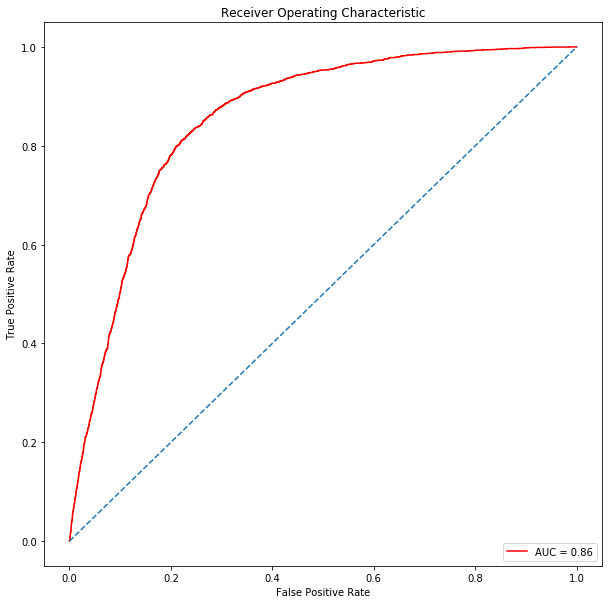

In [27]:
ROC(labels, pred_prob)

### 5.3.2 Testing set

In [28]:
evalset = ClsLineByLineTextDataset(
    tokenizer=BertTokenizer,
    sequence_file_path="./synthetic_eval_X.txt", label_file_path="./synthetic_eval_Y.txt",
    block_size=128,
)

evalloader = DataLoader(evalset, batch_size=200)

pred_prob = []
labels = []

with torch.no_grad():
    for input_id, label in evalloader:
        # True labels
        labels.append(label.squeeze())
        # Predict probability
        logits = model(input_id)[0]
        pred_prob.append(F.softmax(logits, dim=1)[:,1])
        
labels = torch.cat(labels)
pred_prob = torch.cat(pred_prob)
pred_labels = 1 * (pred_prob > 0.5)

In [29]:
print(f'Testing accuracy: {accuracy_score(labels, pred_labels)}.')

confusion_matrix(labels, pred_labels)

Testing accuracy: 0.6965.


array([[5190, 1917],
       [1118, 1775]])

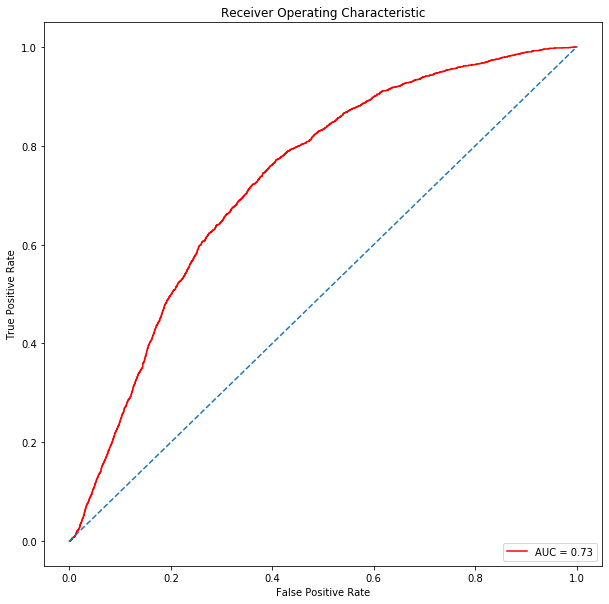

In [30]:
ROC(labels, pred_prob)